In [1]:
%matplotlib inline

#imports
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix

import sqlite3
import xml.etree.ElementTree as ET

from collections import Counter, defaultdict

In [2]:
#load data (sqlite3)
with sqlite3.connect('./data/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)

We have 4 data sets

IDs and names:

* Countries
* Teams
* Leagues

Matches info:

* Matches

Let's see how they look like:

In [3]:
print(countries.shape)
countries

(11, 2)


,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [4]:
print(leagues.shape)
leagues

(11, 3)


,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [5]:
print(teams.shape)
teams.head()

(299, 5)


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [6]:
print(matches.shape)
print(list(matches.columns))
matches.head()

(25979, 115)
['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


We want to predict the results so we are going to focus in only one league and one season. Teams change so much from one year to another that my approach is to predict the second part of the season using the starting with the first one. Let's get the Spanish league (yes, I'm from Spain ... Hala Madrid!!) and the lastest season.

In [7]:
matches.dtypes.iloc[:5]

id             int64
country_id     int64
league_id      int64
season        object
stage          int64
dtype: object

In [8]:
matches.season.value_counts()

2015/2016    3326
2008/2009    3326
2014/2015    3325
2010/2011    3260
2012/2013    3260
2009/2010    3230
2011/2012    3220
2013/2014    3032
Name: season, dtype: int64

In [9]:
# filter by league and season
laliga = matches.loc[(matches['league_id']==21518) & (matches['season']=='2015/2016')]
laliga.reset_index(drop=True, inplace=True)
laliga.shape #all games are 380

(380, 115)

We have 115 colums, we are going to review then in sets of 15 and drop the ones we don't need (odds and players)

In [10]:
# missing values
laliga.isnull().sum()[laliga.isnull().sum() != 0]

home_player_2       1
home_player_4       1
home_player_6       4
home_player_7       2
home_player_8       1
home_player_9       2
home_player_10      1
away_player_2       1
away_player_3       1
away_player_4       2
away_player_5       2
away_player_6       5
away_player_7       4
away_player_8       1
away_player_9       1
PSH                 1
PSD                 1
PSA                 1
SJH               380
SJD               380
SJA               380
GBH               380
GBD               380
GBA               380
BSH               380
BSD               380
BSA               380
dtype: int64

In [11]:
cols = list(laliga.columns)
block_size = 15
col_blocks = [cols[i:i + block_size] for i in range(0, len(cols), block_size)]
print("number of blocks:",len(col_blocks))

number of blocks: 8


## 1st BLOCK

In [12]:
col_blocks[0]

['id',
 'country_id',
 'league_id',
 'season',
 'stage',
 'date',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'home_player_X1',
 'home_player_X2',
 'home_player_X3',
 'home_player_X4']

In [13]:
new_cols = ['id','stage','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal']

## 2nd BLOCK

In [14]:
col_blocks[1]

['home_player_X5',
 'home_player_X6',
 'home_player_X7',
 'home_player_X8',
 'home_player_X9',
 'home_player_X10',
 'home_player_X11',
 'away_player_X1',
 'away_player_X2',
 'away_player_X3',
 'away_player_X4',
 'away_player_X5',
 'away_player_X6',
 'away_player_X7',
 'away_player_X8']

## 3rd BLOCK

In [15]:
col_blocks[2]

['away_player_X9',
 'away_player_X10',
 'away_player_X11',
 'home_player_Y1',
 'home_player_Y2',
 'home_player_Y3',
 'home_player_Y4',
 'home_player_Y5',
 'home_player_Y6',
 'home_player_Y7',
 'home_player_Y8',
 'home_player_Y9',
 'home_player_Y10',
 'home_player_Y11',
 'away_player_Y1']

## 4th BLOCK

In [16]:
col_blocks[3]

['away_player_Y2',
 'away_player_Y3',
 'away_player_Y4',
 'away_player_Y5',
 'away_player_Y6',
 'away_player_Y7',
 'away_player_Y8',
 'away_player_Y9',
 'away_player_Y10',
 'away_player_Y11',
 'home_player_1',
 'home_player_2',
 'home_player_3',
 'home_player_4',
 'home_player_5']

## 5th BLOCK

In [17]:
col_blocks[4]

['home_player_6',
 'home_player_7',
 'home_player_8',
 'home_player_9',
 'home_player_10',
 'home_player_11',
 'away_player_1',
 'away_player_2',
 'away_player_3',
 'away_player_4',
 'away_player_5',
 'away_player_6',
 'away_player_7',
 'away_player_8',
 'away_player_9']

## 6th BLOCK

In [18]:
col_blocks[5]

['away_player_10',
 'away_player_11',
 'goal',
 'shoton',
 'shotoff',
 'foulcommit',
 'card',
 'cross',
 'corner',
 'possession',
 'B365H',
 'B365D',
 'B365A',
 'BWH',
 'BWD']

In [19]:
new_cols = new_cols + ['goal','shoton','shotoff','foulcommit', 'card', 'cross', 'corner', 'possession']

## 7th BLOCK

In [20]:
col_blocks[6]

['BWA',
 'IWH',
 'IWD',
 'IWA',
 'LBH',
 'LBD',
 'LBA',
 'PSH',
 'PSD',
 'PSA',
 'WHH',
 'WHD',
 'WHA',
 'SJH',
 'SJD']

## 8th BLOCK

In [21]:
col_blocks[7]

['SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA']

We have drop all columns related to odds and players. Let's now:


* Missing values
* Distribution (if it makes sense)
* Outliers
* Do I need it? is it redundant?
* Types, Formatting


In [23]:
laliga = laliga[new_cols]
laliga.drop('goal', axis=1, inplace=True)
print(laliga.isnull().sum())
laliga.head()

id                  0
stage               0
home_team_api_id    0
away_team_api_id    0
home_team_goal      0
away_team_goal      0
shoton              0
shotoff             0
foulcommit          0
card                0
cross               0
corner              0
possession          0
dtype: int64


,id,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,24178,1,8581,9910,1,2,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>r</comment><stats><rcard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>35</comment><stats...
1,24179,1,9906,8306,1,0,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><stats...
2,24180,1,9864,8302,0,0,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><stats...
3,24181,1,8315,8634,0,1,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>19</comment><stats...
4,24182,1,7878,8372,1,3,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><stats...


In [ ]:
teams[teams["team_long_name"]=="Real Madrid CF"]

In [ ]:
#from pandas.tools.plotting import scatter_matrix
#pd.tools.plotting.scatter_matrix(laliga, alpha=0.2, figsize=(6, 6), diagonal='kde')

## home_team_goal

1     124
2      89
0      85
3      45
4      19
5      11
6       5
10      1
7       1
Name: home_team_goal, dtype: int64


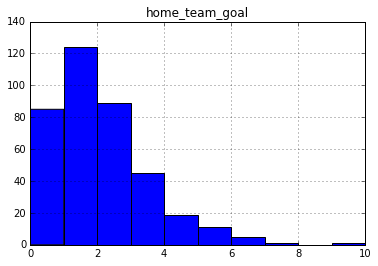

In [24]:
print(laliga["home_team_goal"].value_counts())
laliga["home_team_goal"].hist()
plt.title("home_team_goal")
plt.show()

## away_team_goal


1    135
0    129
2     77
3     27
4      6
5      4
8      1
6      1
Name: away_team_goal, dtype: int64


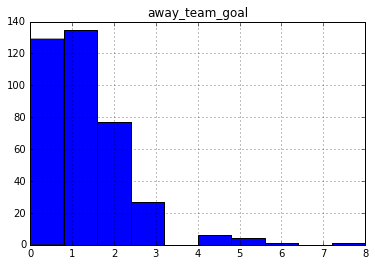

In [25]:
print(laliga["away_team_goal"].value_counts())
laliga["away_team_goal"].hist()
plt.title("away_team_goal")
plt.show()

In [26]:
#pretty print xml
#import xml.dom.minidom
#xml = xml.dom.minidom.parseString(laliga.card.iloc[100])
#pretty_xml_as_string = xml.toprettyxml()
#print(pretty_xml_as_string)

## Possession

In [27]:
def possession (pos_xml):
    # returns set 0: home 1: away
    root = ET.fromstring(pos_xml)
    values = root.findall('value')
    value = values[-1]
    return (value.find('homepos').text,value.find('awaypos').text)

laliga["possesion_home"] = (laliga['possession'].map(possession)).map(lambda x: x[0])
laliga["possesion_away"] = (laliga['possession'].map(possession)).map(lambda x: x[1])
laliga.drop('possession', axis=1, inplace=True)

The function below returns dict with ocurrences of each team in an xml string

In [28]:
def home_away (pos_xml):
    # returns dict with ocurrences of each team in an xml string
    ocurrences = []
    root = ET.fromstring(pos_xml)
    for value in root.findall('value'):
        for team in value.findall('team'):
            ocurrences.append(team.text)
    return Counter(ocurrences)

## Shoton/Shotoff

In [29]:
def shoton_home (row):
    team = row['home_team_api_id']
    return row['shoton'][str(team)]

def shoton_away (row):
    team = row['away_team_api_id']
    return (row['shoton'][str(team)])


laliga['shoton'] = laliga['shoton'].map(home_away)
laliga['shoton_home'] = laliga.apply(shoton_home, axis=1) 
laliga['shoton_away'] = laliga.apply(shoton_away, axis=1)
laliga.drop('shoton', axis=1, inplace=True)

In [30]:
def shotoff_home (row):
    team = row['home_team_api_id']
    return row['shotoff'][str(team)]

def shotoff_away (row):
    team = row['away_team_api_id']
    return (row['shotoff'][str(team)])


laliga['shotoff'] = laliga['shotoff'].map(home_away)
laliga['shotoff_home'] = laliga.apply(shotoff_home, axis=1) 
laliga['shotoff_away'] = laliga.apply(shotoff_away, axis=1)
laliga.drop('shotoff', axis=1, inplace=True)

## Fouls

In [31]:
def foul_home (row):
    team = row['home_team_api_id']
    return row['foulcommit'][str(team)]

def foul_away (row):
    team = row['away_team_api_id']
    return (row['foulcommit'][str(team)])


laliga['foulcommit'] = laliga['foulcommit'].map(home_away)
laliga['foul_home'] = laliga.apply(foul_home, axis=1) 
laliga['foul_away'] = laliga.apply(foul_away, axis=1)
laliga.drop('foulcommit', axis=1, inplace=True)

## Cross

In [32]:
def cross_home (row):
    team = row['home_team_api_id']
    return row['cross'][str(team)]

def cross_away (row):
    team = row['away_team_api_id']
    return (row['cross'][str(team)])


laliga['cross'] = laliga['cross'].map(home_away)
laliga['cross_home'] = laliga.apply(cross_home, axis=1) 
laliga['cross_away'] = laliga.apply(cross_away, axis=1)
laliga.drop('cross', axis=1, inplace=True)

## Corners

In [33]:
def corner_home (row):
    team = row['home_team_api_id']
    return row['corner'][str(team)]

def corner_away (row):
    team = row['away_team_api_id']
    return (row['corner'][str(team)])


laliga['corner'] = laliga['corner'].map(home_away)
laliga['corner_home'] = laliga.apply(corner_home, axis=1) 
laliga['corner_away'] = laliga.apply(corner_away, axis=1)
laliga.drop('corner', axis=1, inplace=True)

## Cards

In [34]:
def cards (pos_xml):
    # returns dict with fouls of each team
    teams = []
    color=[]
    root = ET.fromstring(pos_xml)
    for value in root.findall('value'):
        for team in value.findall('team'):
            teams.append(team.text)
        for ctype in value.findall('card_type'):
            color.append(ctype.text)
            
    cards_yellow = defaultdict(int)
    cards_red = defaultdict(int)
    
    for t,team in enumerate(teams):
        if color[t] == 'y':
            cards_yellow[team] += 1
        elif color[t] == '2y':
            cards_yellow[team] += 1
        elif color[t] == 'r':
            cards_red[team] += 1
    
    return (cards_yellow, cards_red)


#cards(laliga.card.iloc[100])[1] ['8rq560']  


def cards_home_yellow (row):
    team = row['home_team_api_id']
    return row['card'][0][str(team)]

def cards_home_red (row):
    team = row['home_team_api_id']
    return (row['card'][1][str(team)])

def cards_away_yellow (row):
    team = row['away_team_api_id']
    return row['card'][0][str(team)]

def cards_away_red (row):
    team = row['away_team_api_id']
    return (row['card'][1][str(team)])


laliga['card'] = laliga['card'].map(cards)

laliga['cards_home_yellow'] = laliga.apply(cards_home_yellow, axis=1)
laliga['cards_home_red'] = laliga.apply(cards_home_red, axis=1)
laliga['cards_away_yellow'] = laliga.apply(cards_away_yellow, axis=1)
laliga['cards_away_red'] = laliga.apply(cards_away_red, axis=1)


laliga.drop('card', axis=1, inplace=True)

In [37]:
laliga.columns

Index(['id', 'stage', 'home_team_api_id', 'away_team_api_id', 'home_team_goal',
       'away_team_goal', 'possesion_home', 'possesion_away', 'shoton_home',
       'shoton_away', 'shotoff_home', 'shotoff_away', 'foul_home', 'foul_away',
       'cross_home', 'cross_away', 'corner_home', 'corner_away',
       'cards_home_yellow', 'cards_home_red', 'cards_away_yellow',
       'cards_away_red'],
      dtype='object')

In [36]:
laliga.head(10)

,id,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,possesion_home,possesion_away,shoton_home,shoton_away,...,foul_home,foul_away,cross_home,cross_away,corner_home,corner_away,cards_home_yellow,cards_home_red,cards_away_yellow,cards_away_red
0,24178,1,8581,9910,1,2,36,64,3,7,...,13,17,17,8,4,6,1,1,3,0
1,24179,1,9906,8306,1,0,62,38,5,1,...,11,16,19,2,4,4,2,0,0,0
2,24180,1,9864,8302,0,0,53,47,9,3,...,19,10,17,21,7,2,3,0,4,0
3,24181,1,8315,8634,0,1,32,68,4,5,...,16,11,15,14,2,4,3,0,3,0
4,24182,1,7878,8372,1,3,58,42,6,4,...,5,23,17,16,6,5,1,1,6,0
5,24183,1,8558,8305,1,0,37,63,1,6,...,19,14,7,16,4,6,2,0,4,0
6,24184,1,8603,10205,1,1,62,38,8,3,...,11,26,37,12,7,5,3,0,1,1
7,24185,1,9869,8633,0,0,31,69,0,10,...,19,3,18,28,2,5,4,0,0,0
8,24186,1,9783,8560,0,0,58,42,7,8,...,16,10,22,24,5,4,3,0,2,0
9,24187,1,8370,10267,0,0,58,42,6,4,...,19,12,22,19,3,3,3,0,1,0


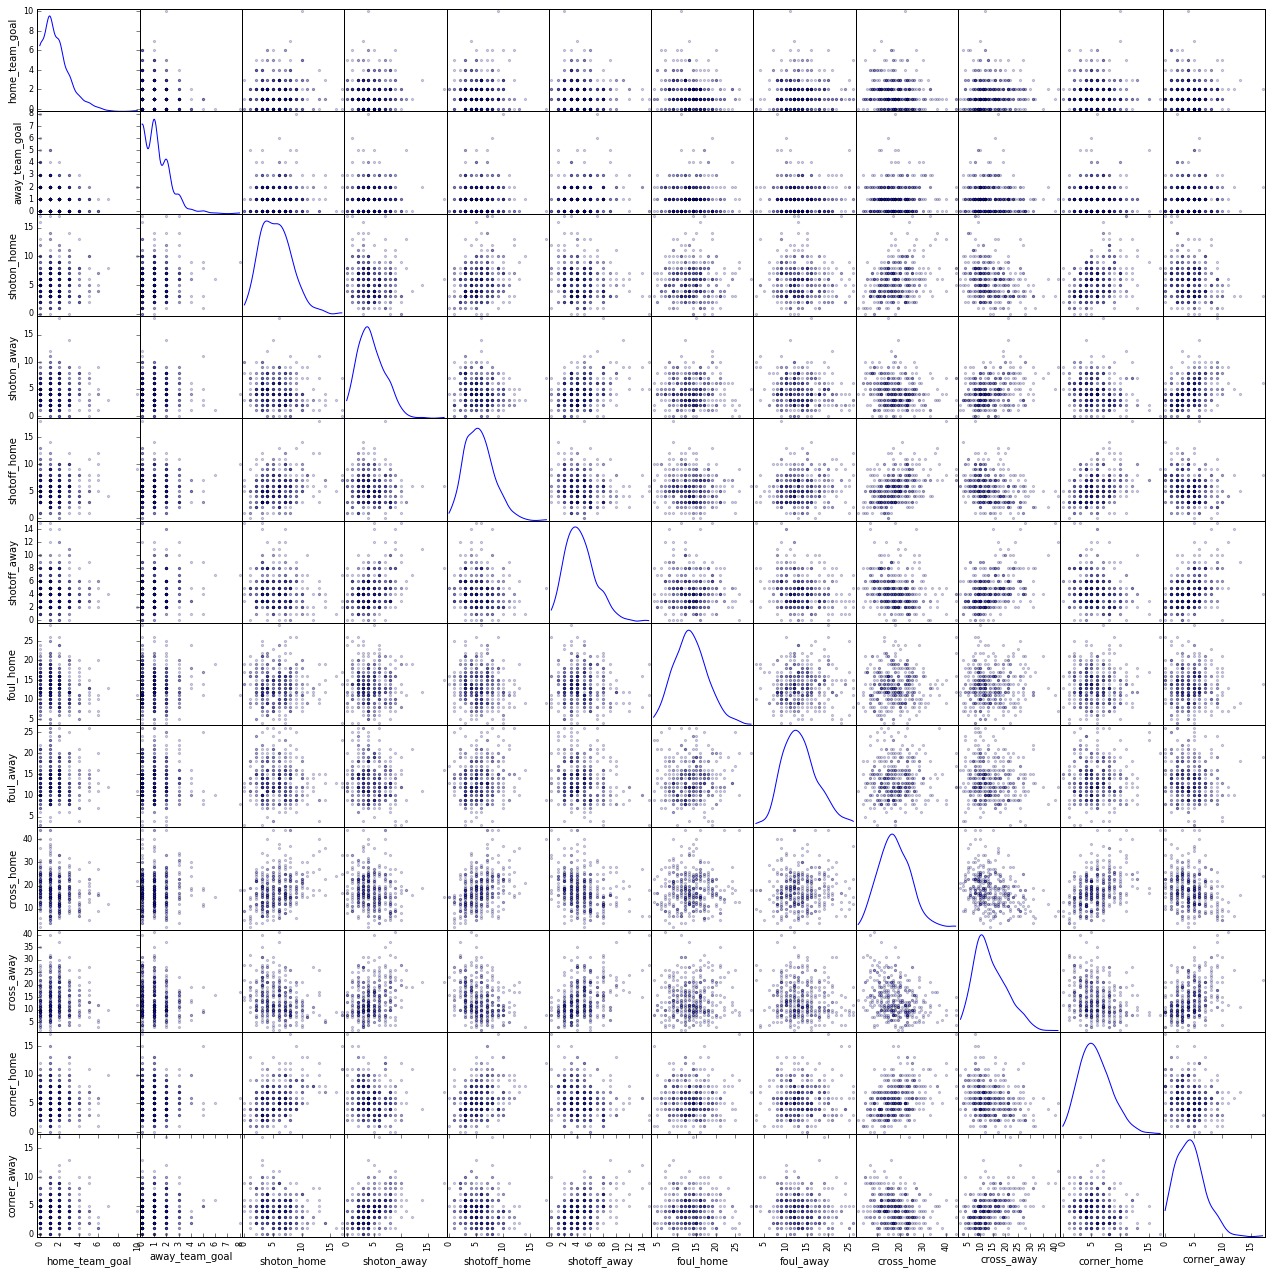

In [50]:
columns = ['home_team_goal','away_team_goal','possesion_home', 'possesion_away', 'shoton_home',
           'shoton_away', 'shotoff_home', 'shotoff_away', 'foul_home', 'foul_away',
           'cross_home', 'cross_away', 'corner_home', 'corner_away']
pd.tools.plotting.scatter_matrix(laliga[columns], alpha=0.2, figsize=(22, 22), diagonal='kde')
plt.show()

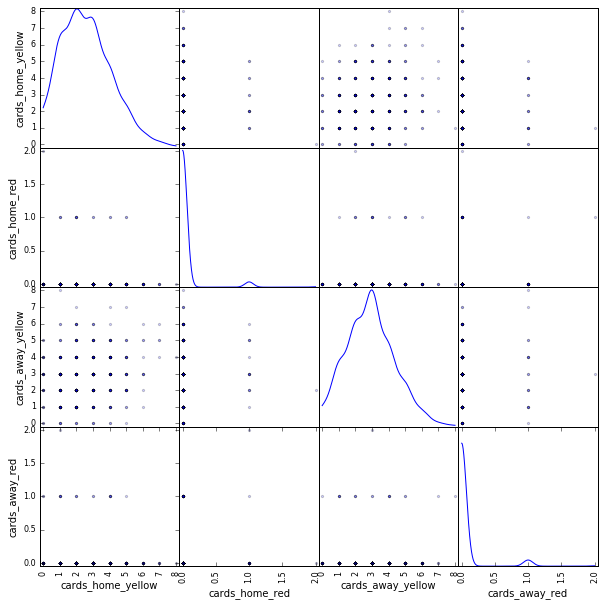

In [49]:
columns = ['cards_home_yellow', 'cards_home_red', 'cards_away_yellow','cards_away_red']
pd.tools.plotting.scatter_matrix(laliga[columns], alpha=0.2, figsize=(10, 10), diagonal='kde')
plt.show()